In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)

# TODO Add explanation of polynomial basis linear model

In [8]:
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]

poly_degree = 4
x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.2, indicator_cols, y_cols)

x_train_standardized = data.standardize_cols(x_train_raw)
x_test_standardized = data.standardize_cols(x_test_raw)

# TODO: highlight the polynomial function
x_train = basis_functions.polynomial(x_train_standardized, degree=poly_degree)
x_test = basis_functions.polynomial(x_test_standardized, degree=poly_degree)

vis = x_train_raw.copy(deep=True)
vis["trip_duration"] = y_train_raw.copy(deep=True)

# Model

Now, we will remain with the same GLM, however we apply a polynomial basis function to our data.

In [5]:
N, D = x_train.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)
alpha = ed.models.Normal(loc=[0.0], scale=1.0)
Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=alpha)

# Inference

Again, we will use KLqp inference

In [6]:
qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([1])),
                                                   tf.Variable(tf.zeros([1]))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb, alpha: qalpha},
                    data={X: x_train.as_matrix(),
                          Y: np.reshape(y_train_raw.as_matrix(), (y_train_raw.shape[0]))})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 2101.077


# Critique

The graph below is a prediction of our data solely as a function of pickup hour, meaning that all other points are held to their mean values as expected by the linear model, i.e. 0.

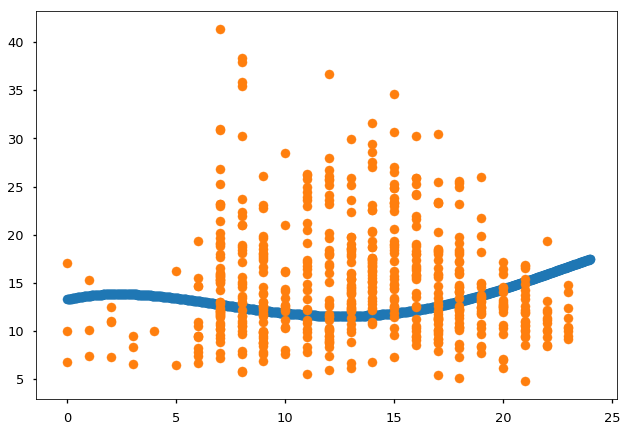

In [10]:
def vis_glm(num_pnts, indicator_cols, actual_data, qw, qb, qalpha):
    times = np.linspace(0, 24, num_pnts)
    x_vis = pd.DataFrame({i: [0.0] * num_pnts for i in indicator_cols})
    x_vis["pickup_hour"] = times
    x_vis["pickup_timestamp"] = x_vis["pickup_hour"].apply(lambda x: pd.to_datetime(x, unit="s").hour)
    x_vis_stndzd = data.standardize_cols(x_vis)
    qw_i = qw.sample().eval()
    qb_i = qb.sample().eval()
    qalpha_i = qalpha.sample().eval()

    x_vis_poly = basis_functions.polynomial(x_vis_stndzd, degree=poly_degree).fillna(0.0)
    line = np.matmul(x_vis_poly, qw_i) + qb_i + qalpha_i

    plt.scatter(x=times, y=line)
    plt.scatter(x=actual_data["pickup_hour"], y=actual_data["trip_duration"])
    plt.show()
vis_glm(1000, indicator_cols, vis, qw, qb, qalpha)

Looking at the simple point estimate to see if we've had any improvement, it's clear that we have. Specifically, our error has shrunk by about 3 minutes. Now coming within 5 minutes of a trip's true duration is a much more useful estimate for someone not familiar with New York City.

In [12]:
N, D = x_test.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, qw) + qb, scale=qalpha)
print(ed.evaluate("mean_absolute_error",
            data={X_eval: x_test.as_matrix(),
                  y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
             output_key=y_posterior_predictive))

5.71375


Now, in order to get a better understanding of what specifically is not being modeled correctly, we will use the posterior predictive checks. It's clear from our graphs that our model is not properly capturing the mean of our data. Within a GLM the main form of adjustment is the basis function and we do not know which basis function would be best for our dataset. From here we need to return to our model again.

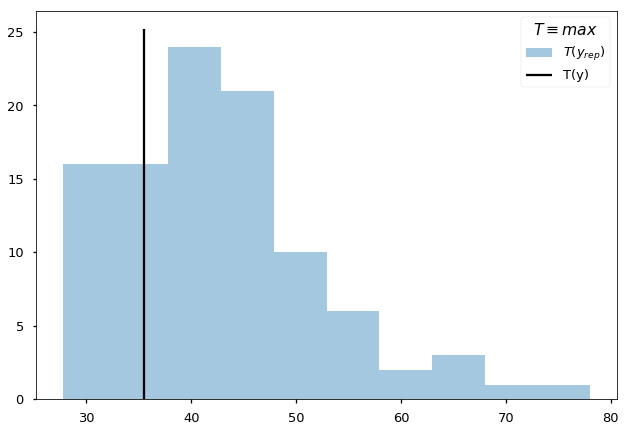

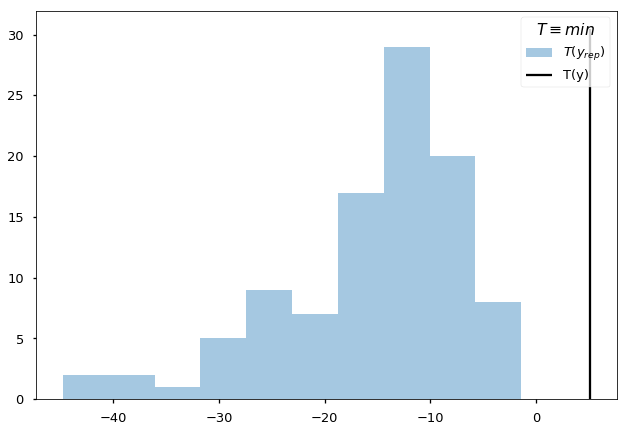

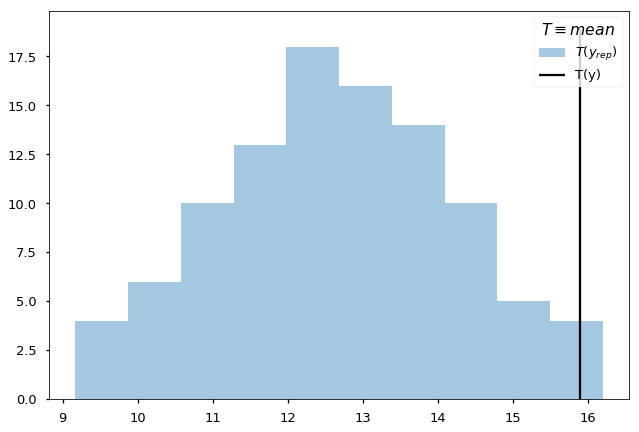

In [14]:
def T_max(data_dict, latent_vars_dict):
    return tf.reduce_max(data_dict[y_posterior_predictive])
def T_min(data_dict, latent_vars_dict):
    return tf.reduce_min(data_dict[y_posterior_predictive])
def T_mean(data_dict, latent_vars_dict):
    return tf.reduce_mean(data_dict[y_posterior_predictive])
ppc_stats_max = ed.ppc(T_max,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )
ppc_stats_min = ed.ppc(T_min,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )
ppc_stats_mean = ed.ppc(T_mean,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )

ed.ppc_stat_hist_plot(ppc_stats_max[1][1], ppc_stats_max[0], stat_name=r'$T \equiv max$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_min[1][1], ppc_stats_min[0], stat_name=r'$T \equiv min$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_mean[1][1], ppc_stats_mean[0], stat_name=r'$T \equiv mean$',
    bins=10)
plt.show()